In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
ticker = 'AAPL'  # Apple Inc.
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')


[*********************100%%**********************]  1 of 1 completed


In [3]:
data = data['Close'].values
data = data.reshape(-1, 1)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

In [6]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [11]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

2516/2516 [==============================] - 137s 53ms/step - loss: 2.1280e-04


In [12]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

18/18 [==============================] - 0s 23ms/step


In [13]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [14]:
import math
from sklearn.metrics import mean_squared_error
train_score = math.sqrt(mean_squared_error(y_train, train_predict))
test_score = math.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train Score: {train_score} RMSE')
print(f'Test Score: {test_score} RMSE')

Train Score: 31.503910277163172 RMSE
Test Score: 138.48483377642023 RMSE


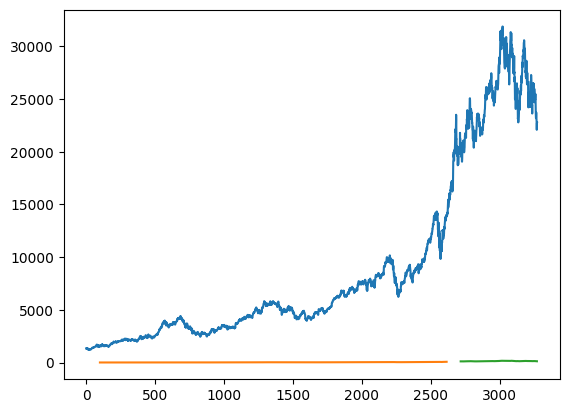

In [15]:
look_back = 100
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
plt.plot(scaler.inverse_transform(data))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()